In [1]:
%%javascript
function ClickConnect(){
  console.log("Working");
  document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/camera_calibration'

Mounted at /content/gdrive


In [3]:
import numpy as np
import cv2
import glob
import os

# 1.1 数据准备

In [4]:
# 设置终止条件，迭代 30 次或移动 0.001
# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# 准备对象点（0,0,0), (1,0,0), (2,0,0) ....,(3,4,0)
h, w = 3, 4
images = glob.glob(os.path.join(root_path, 'checkerboard_l', '*.JPG'))

# 1.2 角点提取

(获取角点两个坐标系下的坐标，作为求解方程中的已知量)

首先，基于cv2.findChessboardCorners寻找棋盘格角点：



In [5]:
# 定位角点
def find_chessboard_cor(img, h, w):
  # 转为灰度图
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # OpenCV内置函数提取棋盘格角点, (6,9)为棋盘格尺寸-1(7x10)
  is_success, corner_origin = cv2.findChessboardCorners(gray_img, (h ,w), None)
  # 计算亚像素时停止迭代的标准
  # 后者表示迭代次数达到了最大次数时停止，前者表示角点位置变化的最小值已经达到最小时停止迭代
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
  # 亚像素角点检测，提高角点定位精度, (7, 7)为考虑角点周围区域的大小
  if is_success:
    corner = cv2.cornerSubPix(gray_img, corner_origin, (11, 11), (-1, -1), criteria)
  else:
    corner = corner_origin
  return is_success, corner, corner_origin

值得注意的是，这里我们必须使用cv2.cornerSubPix再进行一次迭代定位亚像素角点，使得角点的定位更为精确。



基于cv2.drawChessboardCorners可视化棋盘格角点：



In [ ]:
from google.colab.patches import cv2_imshow
# 可视化角点
def draw_chessboard_cor(img, cor, is_success, h, w):
  cv2.drawChessboardCorners(img, (h ,w), cor, is_success)
  cv2_imshow(img)
  cv2.waitKey(0)

In [ ]:
img = cv2.imread(images[0])
is_success, corner, corner_origin = find_chessboard_cor(img, h, w)
draw_chessboard_cor(img, corner, is_success, h, w)
draw_chessboard_cor(img, corner_origin, is_success, h, w)

提取了棋盘格角点坐标的目的：这一步是为了获取角点在图像坐标系中的坐标。为了求解相机内外参矩阵，紧接着我们还需要获取棋盘格在原始世界坐标系中的坐标。

值得一提的是，无论是固定相机移动棋盘格进行拍摄，还是固定棋盘格移动相机进行拍摄，在张正友标定法的假设中，棋盘格永远处在世界坐标系Z=0的平面上，棋盘格最左上角的角点为世界坐标系原点，往右为x轴正方向，往下为y轴正方向

由于同一张标定板的规格不会改变，因此，世界坐标系通过人为定义即可


# 1.3 参数求解

In [6]:
# 求解内外参数
def CamCalibrate(h, w, images):
  # 图像缩放比例(如果你的图像进行了缩放，与实际拍摄的分辨率不一致，最终求得的参数需要乘上这个比例进行校正)
  ratio = 1 # 3648 / 1920
  world, cam = [], []
  # 多张图像进行标定，减小误差:
  i = 0
  for img in images:
    img = cv2.imread(img)
    # img,_,_ = utils.auto_reshape(img, 1920)
    # 定位角点
    is_success, cam_coord, cam_coord_origin = find_chessboard_cor(img, h, w)
    if is_success is not True :
      continue
    print('第'+str(i+1)+'张角点提取完毕, 角点数 =',cam_coord.shape[0])
    # 可视化角点
    # draw_chessboard_cor(img, cam_coord, is_success)
    # 角点的世界坐标:
    # 注:相机参数的计算只要求角点之间的世界坐标比例一致,因此可以单位化
    world_coord = np.zeros((w * h, 3), np.float32)
    world_coord[:, :2] = np.mgrid[0:h, 0:w].T.reshape(-1, 2)
    # world_coord[:,1] = -world_coord[:,1]
    # world_coord[:,:2] = np.mgrid[0:w*len:len,0:h*len:len].T.reshape(-1,2)
    # 将世界坐标与像素坐标加入待求解系数矩阵
    world.append(world_coord)
    cam.append(cam_coord)
    i += 1
  # 求解摄像机的内在参数和外在参数
  # ret 非0表示标定成功 mtx 内参数矩阵，dist 畸变系数，rvecs 旋转向量，tvecs 平移向量
  # 注:求解的结果的单位为像素,若想化为度量单位还需乘上每个像素代表的实际尺寸(如:毫米/像素)
  ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(world, cam, (img.shape[1], img.shape[0]), None, None)
  rvecs = np.array(rvecs).reshape(-1,3)
  tvecs = np.array(tvecs).reshape(-1,3)
  # 单位:像素(1像素=??mm)
  print("标定结果 ret:", ret)
  print("内参矩阵 mtx:", mtx) # 内参数矩阵
  print("畸变系数 dist:", dist) # 畸变系数 distortion cofficients = (k_1,k_2,p_1,p_2,k_3)
  print("旋转向量(外参) rvecs:", rvecs) # 旋转向量 # 外参数(欧拉角)
  print("平移向量(外参) tvecs:", tvecs) # 平移向量 # 外参数
  #np.save('./param/mtx.npy',mtx)
  #np.save('./param/dist.npy',dist)
  #np.save('./param/rvecs.npy',rvecs)
  #np.save('./param/tvecs.npy',tvecs)
  #np.save('./param/world.npy',np.array(world))
  #np.save('./param/cam.npy',np.array(cam))
  return ret, world, cam, mtx, dist, rvecs, tvecs

In [7]:
ret, world, cam, mtx, dist, rvecs, tvecs = CamCalibrate(h, w, images)

第1张角点提取完毕, 角点数 = 12
第2张角点提取完毕, 角点数 = 12
第3张角点提取完毕, 角点数 = 12
第4张角点提取完毕, 角点数 = 12
第5张角点提取完毕, 角点数 = 12
第6张角点提取完毕, 角点数 = 12
第7张角点提取完毕, 角点数 = 12
第8张角点提取完毕, 角点数 = 12
第9张角点提取完毕, 角点数 = 12
第10张角点提取完毕, 角点数 = 12
第11张角点提取完毕, 角点数 = 12
第12张角点提取完毕, 角点数 = 12
第13张角点提取完毕, 角点数 = 12
第14张角点提取完毕, 角点数 = 12
第15张角点提取完毕, 角点数 = 12
第16张角点提取完毕, 角点数 = 12
第17张角点提取完毕, 角点数 = 12
第18张角点提取完毕, 角点数 = 12
第19张角点提取完毕, 角点数 = 12
第20张角点提取完毕, 角点数 = 12
第21张角点提取完毕, 角点数 = 12
第22张角点提取完毕, 角点数 = 12
第23张角点提取完毕, 角点数 = 12
第24张角点提取完毕, 角点数 = 12
第25张角点提取完毕, 角点数 = 12
第26张角点提取完毕, 角点数 = 12
第27张角点提取完毕, 角点数 = 12
第28张角点提取完毕, 角点数 = 12
标定结果 ret: 0.7900622738794819
内参矩阵 mtx: [[1.38192523e+04 0.00000000e+00 3.10268271e+03]
 [0.00000000e+00 1.38082229e+04 2.02005129e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
畸变系数 dist: [[ 4.81377531e-02  3.02889481e+00  3.88362192e-04  2.56678203e-03
  -6.92609204e+01]]
旋转向量(外参) rvecs: [[-6.06284861e-02 -5.17457434e-02 -1.58143081e+00]
 [-1.05203389e-01  2.79002564e-04 -1.59903377e+00]
 [-1.81909021e-01  5.6

# 1.4 参数评估（重投影误差）
可以使用OpenCV内置的cv2.projectPoints()直接计算重投影误差

也可以自己实现：
（OpenCV的旋转向量转旋转矩阵基于Rodriguez变换）

In [8]:
# 旋转向量转旋转矩阵
def Rodriguez(rvecs):
  # 旋转向量模长
  θ = (rvecs[0] * rvecs[0] + rvecs[1] * rvecs[1] + rvecs[2] * rvecs[2])**(1/2)
  # 旋转向量的单位向量
  r = rvecs / θ
  # 旋转向量单位向量的反对称矩阵
  anti_r = np.array([
      [0, -r[2], r[1]],
      [r[2], 0, -r[0]],
      [-r[1], r[0], 0]
      ])
  # 旋转向量转旋转矩阵(Rodriguez公式) # np.outer(r, r) = r @ r.T 向量外积
  M = np.eye(3) * np.cos(θ) + (1 - np.cos(θ)) * np.outer(r, r) + np.sin(θ) * anti_r
  return M

# 计算重投影坐标
def CalcProjectPoints(world, rvecs, tvecs, mtx, dist):
  # 旋转向量转旋转矩阵
  M = Rodriguez(rvecs)
  # c = Rw + t (世界坐标系转相机坐标系)
  R_t = (M @ world.T).T + tvecs
  # (相机坐标系到图像坐标系)
  # print(R_t)
  plain_pts = (mtx @ R_t.T)
  plain_pts = (plain_pts / plain_pts[2,:]).T[:,:2]
  # 去畸变
  c_xy = np.array([mtx[0,2], mtx[1,2]])
  f_xy = np.array([mtx[0,0], mtx[1,1]])
  k1, k2, p1, p2, k3 = dist[0]
  x_y = (plain_pts - c_xy) / f_xy
  r = np.sum(x_y * x_y, 1)
  x_distorted = x_y[:,0] * (1 + k1*r + k2*r*r + k3*r*r*r) + 2*p1*x_y[:,0]*x_y[:,1] + p2*(r + 2*x_y[:,0]*x_y[:,0])
  y_distorted = x_y[:,1] * (1 + k1*r + k2*r*r + k3*r*r*r) + 2*p2*x_y[:,0]*x_y[:,1] + p1*(r + 2*x_y[:,1]*x_y[:,1])
  u_distorted = f_xy[0]*x_distorted + c_xy[0]
  v_distorted = f_xy[1]*y_distorted + c_xy[1]
  plain_pts = np.array([u_distorted,v_distorted]).T
  return plain_pts

OpenCV同样内置cv2.norm()求解RMSE，当然也可以自己实现：



In [9]:
# 重投影可视化
def drawReprojCor(img, original_pts, reprojec_pts, idx):
  r,g = (0,0,255),(0,255,0)
  for i in range(original_pts.shape[0]):
    # 原始角点
    x0, y0 = int(round(original_pts[i,0])), int(round(original_pts[i,1]))
    cv2.circle(img, (x0, y0), 10, g, 2, lineType=cv2.LINE_AA)
    # 重投影角点
    x1, y1 = int(round(reprojec_pts[i,0])), int(round(reprojec_pts[i,1]))
    cv2.circle(img, (x1, y1), 10, r, 2, lineType=cv2.LINE_AA)
  cv2.imwrite(root_path + '/result/'+ str(idx+1)+'.jpg', img)

# 计算重投影误差:
def CalcReprojError(images, world, cam, mtx, dist, rvecs, tvecs):
  errors = []
  for i in range(len(images)):
    # 计算重投影坐标(dist=0不考虑畸变)
    reproj, _ = cv2.projectPoints(world[i], rvecs[i], tvecs[i], mtx, dist)
    #reproj = CalcProjectPoints(world[i], rvecs[i], tvecs[i], mtx, dist)
    # 原始坐标
    original_pts = cam[i].reshape(cam[i].shape[0], 2)
    # 重投影坐标
    reprojec_pts = reproj.reshape(reproj.shape[0], 2)
    # RMSE
    error = cv2.norm(cam[i],reproj, cv2.NORM_L2) / reproj.shape[0]
    errors.append(error)
    # 重投影可视化
    img = cv2.imread(images[i])
    # img,_,_ = utils.auto_reshape(img, 1920)
    drawReprojCor(img, original_pts, reprojec_pts, i)
  return errors

用条形图统计每一张的误差：

In [10]:
import matplotlib.pyplot as plt
# 误差条形图
# 可视化每张图像的误差(单位:像素)
num = len(images)
errors = CalcReprojError(images, world, cam, mtx, dist, rvecs, tvecs)

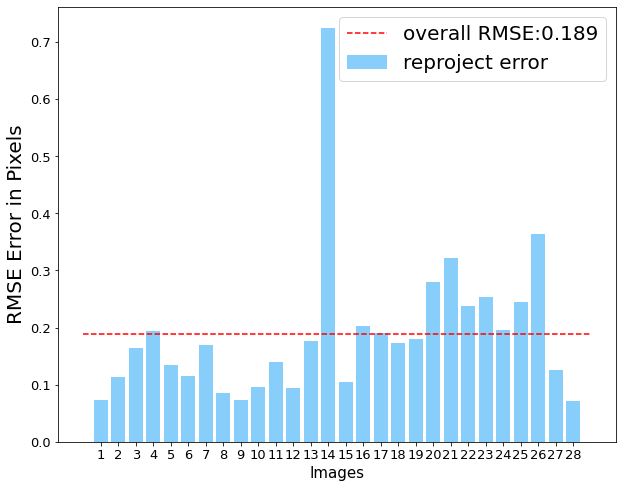

In [11]:
plt.figure(figsize=(10,8))
plt.bar(range(num), errors, width=0.8, label='reproject error', color='#87cefa')
# 误差平均值(单位:像素)
mean_error = sum(errors) / num
plt.plot([-1,num], [mean_error,mean_error], color='r', linestyle='--',label='overall RMSE:%.3f'%(mean_error))
plt.xticks(range(num), range(1,num+1), size=13)
plt.yticks(size=13)
plt.ylabel('RMSE Error in Pixels', fontsize=20)
plt.xlabel('Images', fontsize=15)
plt.legend(prop={'size': 20})
plt.savefig(root_path+'/result/reproject_error.png', bbox='tight', dpi=300)

# 1.5 相机姿态可视化
可视化相机位姿的核心思路就是将相机坐标系下的相机坐标通过外参矩阵(旋转+平移)转换到世界坐标系：



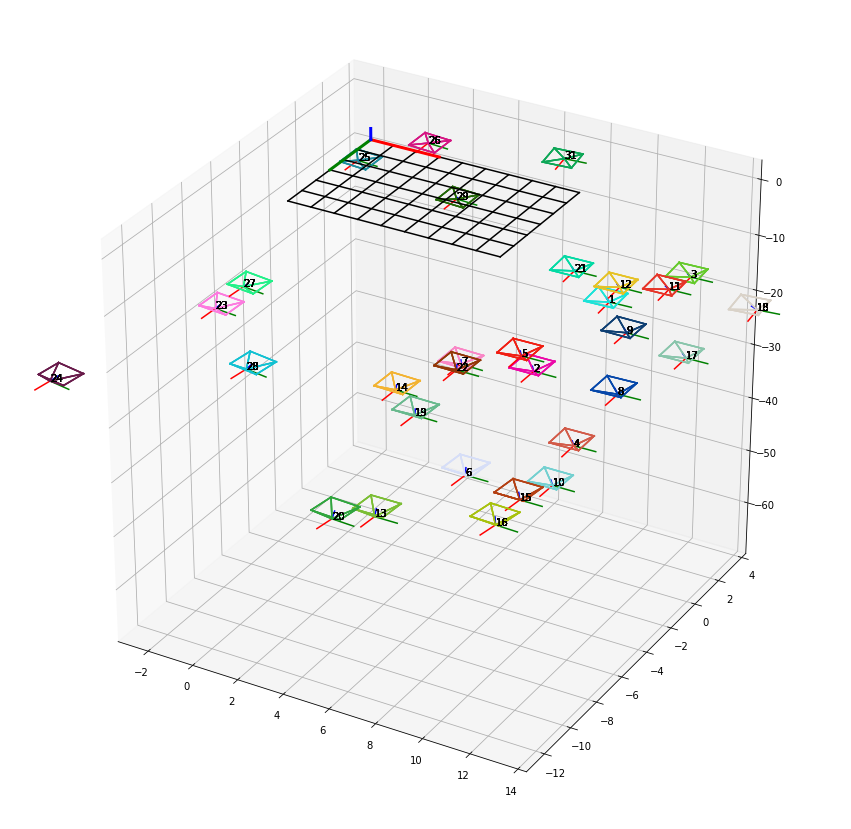

In [ ]:
import random
# 可视化标定过程中的相机位姿
def show_cam_pose(rvecs, tvecs, h, w):
  # 相机坐标系下基向量
  vec = np.array([[1,0,0],[0,1,0],[0,0,1]])
  # 相机位姿模型
  cam = (2/3)*np.array([[1, 1, 2],[-1, 1, 2],[-1, -1, 2],[1, -1, 2],[1, 1, 2]])
  fig = plt.figure(figsize=(15,15))
  ax = fig.add_subplot(111, projection='3d')
  # 绘制每一个角度拍摄的相机
  for i in range(rvecs.shape[0]):
    # 旋转向量转旋转矩阵
    M = Rodriguez(rvecs[i,:])
    # 相机原点 w = R^(-1)(0 - t)
    x0,y0,z0 = M.T @ (-tvecs[i,:])
    c = ['r','g','b']
    # 随机颜色
    hex = '0123456789abcdef'
    rand_c = '#'+''.join([hex[random.randint(0,15)] for _ in range(6)])
    # 绘制相机坐标系
    for j in range(3):
      # 相机位姿(相机坐标系转世界坐标系)
      # w = R^(-1)(c - t)
      x1,y1,z1 = M.T @ (vec[j,:] - tvecs[i,:])
      # 相机坐标系
      ax.plot([x0,x1],[y0,y1],[z0,z1],color=c[j])
      C = (M.T @ (cam - tvecs[i,:]).T).T
      # 绘制相机位姿
      for k in range(4):
        ax.plot([C[k,0],C[k+1,0]],[C[k,1],C[k+1,1]],[C[k,2],C[k+1,2]], color=rand_c)
        ax.plot([x0,C[k+1,0]],[y0,C[k+1,1]],[z0,C[k+1,2]], color=rand_c)
        # 相机编号
        ax.text(x0,y0,z0,i+1)
  # 绘制棋盘格
  for i in range(h+1):
    ax.plot([0, w],[-i, -i],[0,0],color="black")
  for i in range(w+1):
    ax.plot([i, i],[-h, 0],[0,0],color="black")
  # 绘制世界(棋盘格)坐标系
  for i in range(3):
    ax.plot([0, 3*vec[i,0]],[0, -3*vec[i,1]],[0, 2*vec[i,2]],color=c[i],linewidth=3)
  plt.xlim(-3,14)
  plt.ylim(-13,4)

show_cam_pose(rvecs, tvecs)

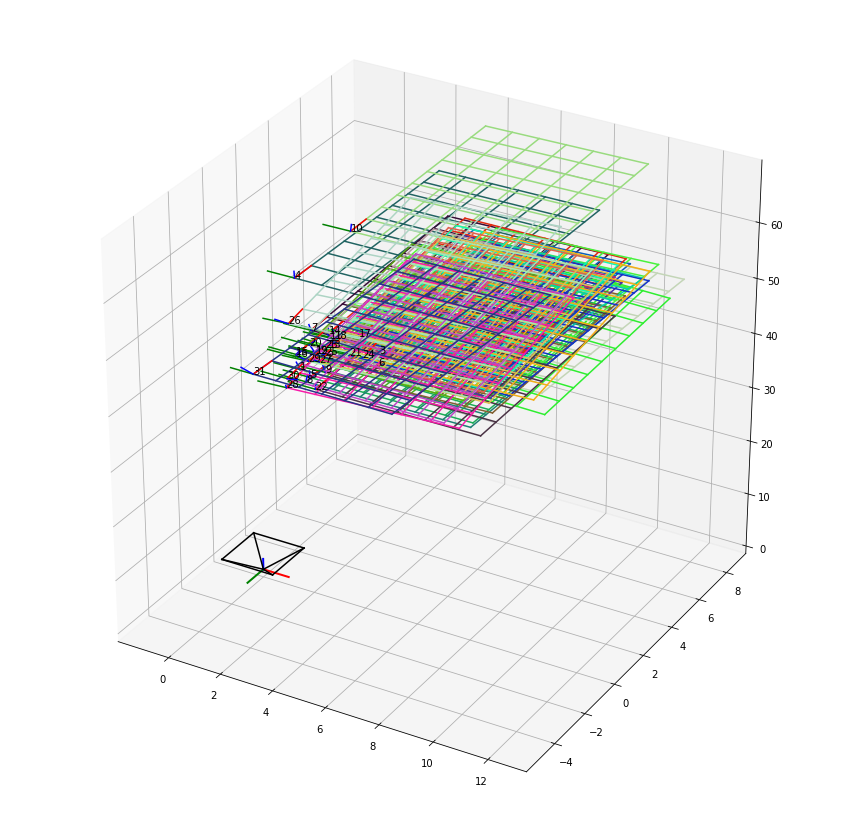

In [ ]:
# 可视化标定过程中的棋盘位姿
def show_chessboard_pose(rvecs, tvecs, h, w):
  # 棋盘坐标系下基向量
  vec = np.array([[1,0,0],[0,1,0],[0,0,1]])
  # 相机位姿模型
  C = np.array([[1, 1, 3],[-1, 1, 3],[-1,-1, 3],[1, -1, 3],[1, 1, 3],])
  fig = plt.figure(figsize=(15, 15))
  ax = fig.add_subplot(111, projection='3d')
  c = ['r','g','b'] # 坐标轴颜色
  # 绘制每一个角度拍摄的棋盘格
  for i in range(rvecs.shape[0]):
    # 旋转向量转旋转矩阵
    M = Rodriguez(rvecs[i,:])
    # 棋盘原点 c = Rw + t
    x0,y0,z0 = tvecs[i,:]
    # 随机颜色
    hex = '0123456789abcdef'
    rand_c = '#'+''.join([hex[random.randint(0,15)] for _ in range(6)])
    # 绘制棋盘位姿
    for k in range(0,h+1):
      b = np.array([[0, -k, 0],[w, -k, 0]])
      b = (M @ b.T + tvecs[i,:].reshape(-1,1)).T
      ax.plot([b[0,0], b[1,0]],[b[0,1], b[1,1]],[b[0,2], b[1,2]],color=rand_c)
    for k in range(0,w+1):
      b = np.array([[k, -h, 0],[k, 0, 0]])
      b = (M @ b.T + tvecs[i,:].reshape(-1,1)).T
      ax.plot([b[0,0], b[1,0]],[b[0,1], b[1,1]],[b[0,2], b[1,2]],color=rand_c)
      k += 11
    # 绘制棋盘坐标系
    for j in range(3):
      # (世界坐标系转相机坐标系)
      # c = Rw + t
      x1,y1,z1 = M @ vec[j,:] + tvecs[i,:]
      ax.plot([x0,x1],[y0,y1],[z0,z1],color=c[j])
    # 棋盘编号
    ax.text(x0,y0,z0,i+1)
  # 绘制世界(相机)坐标系
  for i in range(3):
    ax.plot([0, vec[i,0]],[0, -vec[i,1]],[0, 2*vec[i,2]],color=c[i],linewidth=2)
  # 绘制相机位姿
  for i in range(4):
    ax.plot([C[i,0],C[i+1,0]],[C[i,1],C[i+1,1]],[C[i,2],C[i+1,2]], color="black")
    ax.plot([0,C[i+1,0]],[0,C[i+1,1]],[0,C[i+1,2]], color="black")

show_chessboard_pose(rvecs, tvecs)